In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In this notebook, we will be covering following topics:

- Learning Rate Schedule
- Dropout component

# **Learning Rate Schedule**

In [4]:
# simple 2 layers NN
model = nn.Sequential(
	nn.Linear(2, 5),
	nn.ReLU(),
	nn.Linear(5, 1)
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

We can group the parameters of our model into different groups (will be used for transfer learning later)

- here we only have one group ( each group will be in one list)
- note the learning rate below is 0.001

In [15]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.2197, -0.3686],
           [-0.4251, -0.1346],
           [-0.2628,  0.6199],
           [-0.1249,  0.3726],
           [ 0.0527,  0.5060]], requires_grad=True),
   Parameter containing:
   tensor([-0.0067, -0.4347,  0.1457, -0.4703,  0.5562], requires_grad=True),
   Parameter containing:
   tensor([[-0.0317, -0.1654,  0.3326,  0.2197, -0.3974]], requires_grad=True),
   Parameter containing:
   tensor([-0.3169], requires_grad=True)],
  'lr': 0.0007810416889260659,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'initial_lr': 0.001}]

# why do you think we are getting an error here?


In [8]:
# for every 100 iterations, we gonna change the learning rate
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

# why do you think we are getting an error here?
print(optimizer.param_groups[0]['lr'])
lr_scheduler.step()
print(optimizer.param_groups[0]['lr'])

0.001
0.0009997532801828658


/usr/local/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


the optimizer.step() call is skipped and thus the learning rate scheduler is called before the first parameter update.
We are working on a method to get the last status of the scaler. In the meantime you could try to check if the scale value was reduced and if so skip the learning rate scheduler step.

# Example

https://pytorch.org/docs/stable/optim.html

```raw
model = [Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = SGD(model, 0.1)
scheduler = ExponentialLR(optimizer, gamma=0.9) # optim.lr_scheduler.ExponentialLR()

for epoch in range(20):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()
```


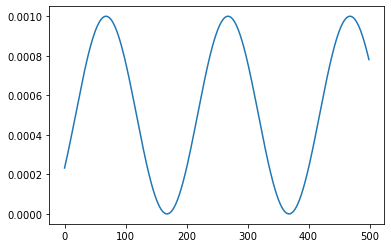

In [14]:
lr_lists = []
for i in range(500):
	lr_scheduler.step()
	lr = optimizer.param_groups[0]["lr"]
	lr_lists.append(lr)

plt.plot(lr_lists)

# Dropout

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.


![example](./img/dropout-capture.gif)



## Why we need Dropout?

- An unregularized network quickly overfits on the training dataset. Notice how the validation loss for without-dropout run diverges a lot after just a few epochs. This accounts for the higher generalization error. 

- Training with two dropout layers with a dropout probability of 25% prevents model from overfitting. However, this brings down the training accuracy, which means a regularized network has to be trained longer. 

- Dropout improves the model generalization. Even though the training accuracy is lower than the unregularized network, the overall validation accuracy has improved. This accounts for a lower generalization error. 

</br>

https://zhang-yang.medium.com/scaling-in-neural-network-dropout-layers-with-pytorch-code-example-11436098d426

https://wandb.ai/authors/ayusht/reports/Dropout-in-PyTorch-An-Example--VmlldzoxNTgwOTE

# How it looks like inside ?

The each element in the weight matrix follow Bernouli Distribution and have `p` probability to be zero-outed.
![example](./img/dropout_weights.png)

In the document, it says

> During trraining, randomly zeroes some of the elements of the input tensor with probability `p` using samples from a Bernoulli Distribution. The elements to zeros are randomized on every forward call. And furthermore, the outputs are scaled by a factor of `1 / (1  - p)` during the training.


This essentially is saying the layer `nn.Dropout(p)` will randomly zero out the elements on the input tensor with the probability `p`, the dropout rate. The result tensor will be scaled by `1 / (1 - p)` (divied by `(1 - p)`) during the training time

Check it out: https://zhang-yang.medium.com/scaling-in-neural-network-dropout-layers-with-pytorch-code-example-11436098d426

**and Let's see an example:**

In [19]:
drop = nn.Dropout(p = 0.8)
x = torch.ones((1000, 1000))

print(x)

y = drop(x)
print(y)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[0., 0., 0.,  ..., 5., 0., 0.],
        [5., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [5., 0., 0.,  ..., 0., 5., 0.]])


In [23]:
torch.count_nonzero(y) / (1000*1000)
# we can see roughly 20% of the element in tensor are non-zeros (80% are zero-outed)
# and those 20% non-zero element would be scaled up from 1 to 5 <===> 1 / (1 - 0.8) = 5 (scaled it back )

tensor(0.2005)

# Why we need to scale the results during training?

And we have a another seneraio in evalidation.

> This means that during the evaludation the modeule simple computes an identity functions

This means that during the evaluation time, the dropout layer will change nothing.

Because `dropout` is active only during training time but not inference time, without the scaling, the expected output would be larger during inference time because the elements are no longer being randomly dropped (set to 0). But we want the expected output with and without going through the dropout layer to be the same. Therefore, during training, we compensate by making the output of the dropout layer larger by the scaling factor of `1/(1−p)`. A larger p means more aggressive dropout, which means the more compensation we need, i.e. the larger the scaling factor `1/(1−p)`.

In [27]:
print(x.mean()) # during training before dropout


tensor(1.)


In [28]:
print(y.mean()) # during training after dropouted

tensor(1.0025)


we can see above that input x and output dropped y will be the roughly the same （这里都是training time)
因为在inference的时候我们没有做zero out这个动作，会导致inference 的tensor数值要普遍大于 training的时候（

# Summary
- model.eval() will keep the output at the same scale.
- This basically says during evaluation/test/inference time, the dropout layer becomes an identity function and makes no change to its input.
- Dropout component is really just adding noise with mean = 0 

# **Categorical Embedding**